In [0]:
%tensorflow_version 1.x

In [42]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [43]:
!unzip /content/Faces_data.zip

Archive:  /content/Faces_data.zip
replace Faces_data/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [0]:
trainx = []
trainy = []
testx = []
testy = []

for i in range(40):
  for j in range(9):
    img = cv2.imread('/content/Faces_data/s'+str(i+1)+'/'+str(j+1)+'.pgm')
    img = np.asarray(img,dtype=np.float32)
    img = img[:,:,0]
    img = img/255.0
    label = i+1
    if j<7:
      trainx.append(img)
      trainy.append(label)
    else:
      testx.append(img)
      testy.append(label)

In [46]:
trainx = np.asarray(trainx)
testx = np.asarray(testx)
trainy= np.asarray(trainy)
testy = np.asarray(testy)
trainx.shape,testx.shape,trainy.shape,testy.shape

((280, 112, 92), (80, 112, 92), (280,), (80,))

In [0]:
img = cv2.imread('/content/Faces_data/s1/1.pgm')

In [0]:
img2 = img[:,:,0]

In [49]:
img2.shape

(112, 92)

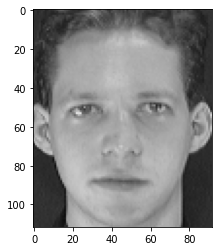

In [50]:
plt.imshow(img,cmap='gray')

In [0]:
def get_batch(size=32,trainx = trainx):
  left = []
  right = []
  truth = []
  
  for _ in range(size):
    n1 = np.random.randint(low=0,high=trainx.shape[0])
    n2 = np.random.randint(low=0,high=trainx.shape[0])

    left.append(trainx[n1])
    right.append(trainx[n2])
    if trainy[n1] == trainy[n2]:
      truth.append(1)
    else:
      truth.append(0)


  left = np.asarray(left,dtype=np.float32).reshape((-1,112,92,1))
  right = np.asarray(right,dtype=np.float32).reshape((-1,112,92,1))

  return [np.asarray(left,dtype=np.float32),np.asarray(right,dtype=np.float32)],np.asarray(truth,dtype=np.float32)
    

In [0]:
v,t = get_batch()

In [0]:
import numpy as np
from keras.layers import Input, Conv2D, Dense, Flatten,MaxPooling2D
from keras.layers import Lambda, Subtract
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

def W_init(shape,name=None,dtype=None):
    """Initialize weights as in paper"""
    values = np.random.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None,dtype=None):
    """Initialize bias as in paper"""
    values = np.random.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (112,92,1)
left_input = Input(input_shape)
right_input = Input(input_shape)

#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

#merge two encoded inputs with the l1 distance between them
subtracted = Subtract()( [encoded_l,encoded_r]  )
both = Lambda(lambda x: abs(x))(subtracted)
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
SiameseNet = Model(inputs=[left_input,right_input],outputs=prediction)

#optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
SiameseNet.compile(loss="binary_crossentropy",optimizer=optimizer)

In [54]:
SiameseNet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 4096)         26364736    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
subtract_3 (Subtract)           (None, 4096)         0           sequential_3[1][0]         

In [55]:
epochs = 150
loss_history = []
best = 0

for i in range(epochs):
  (inputs,truth) = get_batch()
  print(len(inputs))
  print(len(truth))
  loss=SiameseNet.train_on_batch(inputs,truth)
  loss_history.append(loss)
  print(loss)

2
32


FailedPreconditionError: ignored

In [0]:
v=np.asarray(v)
v.shape

In [0]:
test_ = [v[0],v[1]]

In [0]:
testingx,testingy= get_batch(size=150,trainx=testx)

In [0]:
###One photo of every person


In [0]:
testing = []

for i in range(40):
    img = cv2.imread('/content/Faces_data/s'+str(i+1)+'/0.pgm')
    img = np.asarray(img,dtype=np.float32)
    img = img[:,:,0]
    img = img/255.0
    testing.append(img)

(150,)

(150,)

142

2

10